In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from torchvision.transforms import GaussianBlur

C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
image_size = 128
batch_size = 64
def train_augmentation(image, mask, image_size):

    p = 0.5
    
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness=0.5)
    #     image = jitter(image)
    if(random.random() < p):
        angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        translate = (random.uniform(-0.05, 0.05) * image.size[0],
                     random.uniform(-0.05, 0.05) * image.size[1])  # 最多平移 ±5%
        scale = random.uniform(0.95, 1.05)  # 尺度縮放 ±5%
        shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
    
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

    
train_dataset = Thyroid_Dataset("train_v2.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = test_augmentation, image_size = image_size, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

image, mask, seg_type = next(iter(train_dataloader))
image = image
mask = mask

In [5]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))

std :  tensor(1.0000)
unique :  tensor([0., 1.])


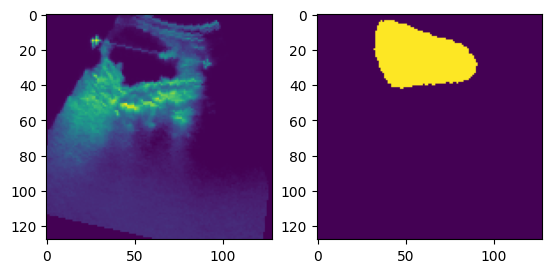

In [6]:
index = 35
plt.subplot(1,2,1)
plt.imshow(image[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

In [7]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1)
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")

In [8]:
# loss_fn_nodule = StructureLoss()
# loss_fn_gland = StructureLoss()

In [9]:
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
# seg_type

In [11]:
# for epoch in range(1000):
#     outputs = model(image)

#     nodule_output = outputs[:, 0:1, :, :][seg_type==1]
#     nodule_mask = mask[seg_type==1]
    
#     gland_output = outputs[:, 1:2, :, :][seg_type==2]
#     gland_mask = mask[seg_type==2]
#     # outputs = torch.sigmoid(logits)
#     # print(nodule_output.shape, nodule_mask.shape)
#     nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
#     gland_loss = loss_fn_gland(gland_output, gland_mask)
    
#     loss = nodule_loss + gland_loss
    
#     IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2
    
#     dice_loss = DiceLoss()
#     # print(dice_loss(nodule_output, nodule_mask))
#     # print(dice_loss(gland_output, gland_mask)) 
#     DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2
    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [12]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(nodule_mask[index][0])
# nodule_output = (nodule_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(nodule_output[index][0].detach().numpy())

In [13]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(gland_mask[index][0])
# gland_output = (gland_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(gland_output[index][0].detach().numpy())

In [14]:
def train(dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, seg_type in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)

        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        
        gland_output = outputs[:, 1:2, :, :][seg_type==2]
        gland_mask = mask[seg_type==2]

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        gland_loss = loss_fn_gland(gland_output, gland_mask)


        
        loss = nodule_loss + gland_loss
        IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2

        dice_loss = DiceLoss()
        DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    DDTI_total_loss = 0
    TN3K_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]


        DDTI_nodule_output = nodule_output[from_dataset==1]
        TN3K_nodule_output = nodule_output[from_dataset==3]

        DDTI_nodule_mask = nodule_mask[from_dataset==1]
        TN3K_nodule_mask = nodule_mask[from_dataset==3]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        DDTI_nodule_loss = loss_fn_nodule(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_nodule_loss = loss_fn_nodule(TN3K_nodule_output, TN3K_nodule_mask)
        
        IOU = IOU_score(nodule_output, nodule_mask)
        DDTI_IOU = IOU_score(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_IOU = IOU_score(TN3K_nodule_output, TN3K_nodule_mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
        DDTI_DICE = 1 - dice_loss(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_DICE = 1 - dice_loss(TN3K_nodule_output, TN3K_nodule_mask)
    

        total_loss += nodule_loss.item()
        DDTI_total_loss += DDTI_nodule_loss.item()
        TN3K_total_loss += TN3K_nodule_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_total_loss/len(dataloader), TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 

In [16]:
epochs = 15
lr = 0.005
project = "thyroid"
name=name="PMFSNet_crop_DDTI_standardization_aug_affine(0.5)_lr_0.005_for_finetune"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [17]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 15, batch size : 64


In [18]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[10, 20, 48, 96],
#         # embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1, out_channels = 2)
# model = LightMed(in_channels = 1, out_channels = 2, image_size = image_size)
model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")

### If using pretrained model

In [19]:
# pretrained_name = "PMFSNet_baseline"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{pretrained_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

In [20]:
# loss_fn = DiceLoss()
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [21]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, DDTI_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,

        "DDTI_val_loss": DDTI_total_loss_val,
        "DDTI_val_IOU": DDTI_total_IOU_val,
        "DDTI_val_DICE": DDTI_total_DICE_val,

        "TN3K_val_loss": TN3K_total_loss_val,
        "TN3K_val_IOU": TN3K_total_IOU_val,
        "TN3K_val_DICE": TN3K_total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:27<00:00,  3.62it/s]

train loss : 1.3341433128508011, train IOU : 0.5222882326729227, train DICE : 0.6688720002622888



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.81s/it]

val loss : 0.8835012674331665, val IOU : 0.449467770755291, val DICE : 0.6083641648292542
epoch : 1



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.79it/s]

train loss : 0.9992655928772275, train IOU : 0.6416634144169269, train DICE : 0.7799017104772058



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.54it/s]

val loss : 0.8032999604940414, val IOU : 0.5037176862359047, val DICE : 0.6721390157938003
epoch : 2



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.83it/s]

train loss : 0.9152239395840334, train IOU : 0.670894194357466, train DICE : 0.8036623048310233



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.27it/s]

val loss : 0.7421911269426346, val IOU : 0.5320711404085159, val DICE : 0.6887698918581009
epoch : 3



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:38<00:00,  2.63it/s]

train loss : 0.8389008818286481, train IOU : 0.6980659046975692, train DICE : 0.8229475995101551



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.91it/s]

val loss : 0.8138817816972732, val IOU : 0.4939751088619232, val DICE : 0.6728263974189759
epoch : 4



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.76it/s]

train loss : 0.7853152386032709, train IOU : 0.7168307581750473, train DICE : 0.8370508693232395



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.04it/s]

val loss : 0.7121108949184418, val IOU : 0.5625621855258942, val DICE : 0.7154228806495666
epoch : 5



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:37<00:00,  2.68it/s]

train loss : 0.741033661483538, train IOU : 0.7328810024969649, train DICE : 0.848422131916084



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.30it/s]

val loss : 0.7098649710416793, val IOU : 0.5550478637218476, val DICE : 0.7172826558351517
epoch : 6



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.75it/s]

train loss : 0.7022294490644247, train IOU : 0.7485134572085768, train DICE : 0.8579405404553555



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.28it/s]

val loss : 0.644003713130951, val IOU : 0.5933874249458313, val DICE : 0.7447217017412185
epoch : 7



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.80it/s]

train loss : 0.6664811478983058, train IOU : 0.7603694896886845, train DICE : 0.865368116610121



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.44it/s]

val loss : 0.6009479343891144, val IOU : 0.6249833256006241, val DICE : 0.7642772018909454
epoch : 8



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.78it/s]

train loss : 0.6300557845889931, train IOU : 0.7739462970507027, train DICE : 0.8750364562072376



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.10it/s]

val loss : 0.8262793987989425, val IOU : 0.5390506312251091, val DICE : 0.7094085961580276
epoch : 9



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]

train loss : 0.6006441435011307, train IOU : 0.78348840404265, train DICE : 0.8821261224180165



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]

val loss : 0.7562498331069947, val IOU : 0.5715987756848335, val DICE : 0.7255950450897217
epoch : 10



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:38<00:00,  2.65it/s]

train loss : 0.5722492042154369, train IOU : 0.7954810904984427, train DICE : 0.8886870334644129



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.25it/s]

val loss : 0.7476067692041397, val IOU : 0.5723918914794922, val DICE : 0.7311058014631271
epoch : 11



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.92it/s]

train loss : 0.5463544136226768, train IOU : 0.8040210457131414, train DICE : 0.8958995472086538



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.86it/s]

val loss : 0.5888251185417175, val IOU : 0.6427848726511002, val DICE : 0.7843709737062454
epoch : 12



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:38<00:00,  2.63it/s]

train loss : 0.5324539341548882, train IOU : 0.809261664895728, train DICE : 0.8983101667744098



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.35it/s]

val loss : 0.606863833963871, val IOU : 0.6434672772884369, val DICE : 0.7850916296243667
epoch : 13



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  2.98it/s]

train loss : 0.5136062992681371, train IOU : 0.8154841838496747, train DICE : 0.902529243785556



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.95it/s]

val loss : 0.5742309480905533, val IOU : 0.6580510199069977, val DICE : 0.7947728157043457
epoch : 14



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:39<00:00,  2.57it/s]

train loss : 0.5050737592253355, train IOU : 0.8200417680315452, train DICE : 0.9049001743297765



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.13it/s]

val loss : 0.5704532206058502, val IOU : 0.6596294850111007, val DICE : 0.7964860498905182


DDTI_val_DICE,▂▄▄▂▅▅▆█▁▃▂▇▇██
DDTI_val_IOU,▂▃▄▁▅▄▆█▁▃▂▇▆▇▇
DDTI_val_loss,▅▄▃▅▃▃▂▁█▆▇▂▃▂▂
Learning Rate,██▇▇▆▆▅▄▃▃▂▂▁▁▁
TN3K_val_DICE,▁▃▄▄▅▅▆▆▆▆▇████
TN3K_val_IOU,▁▃▄▄▅▅▅▆▆▆▇▇███
TN3K_val_loss,█▆▅▅▄▄▃▃▃▃▂▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_DICE,▁▄▅▆▆▆▇▇▇▇█████
train_IOU,▁▄▄▅▆▆▆▇▇▇▇████
train_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁


In [48]:
print(max_IOU)

0.6537312358617783


In [49]:
inference_name = "PMFSNet_baseline"
# model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/last_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

RuntimeError: Error(s) in loading state_dict for PMFSNet:
	size mismatch for out_conv.conv.3.weight: copying a param with shape torch.Size([2, 60, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 60, 3, 3]).
	size mismatch for out_conv.conv.3.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:

total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")


In [ ]:
DICE = 0
# model.to("cuda")
model.eval()
for image, mask in tqdm(test_dataloader):
    image, mask = image, mask
    preds = model(image)
    DICE += (1 - dice_loss(preds, mask)).item()
print(DICE/len(test_dataloader))

In [ ]:
index = 7
plt.subplot(1,2,1)
plt.imshow(preds[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

In [ ]:
dice_loss = DiceLoss()
print(1 - dice_loss(preds, mask))

In [ ]:
plt.imshow(mask[index][0])